In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.ensemble import VotingClassifier
import warnings
warnings.filterwarnings('ignore')

# Data Handling

In [3]:
# load the csv data file into a pandas dataframe and convert class into numerical data
df = pd.read_csv("data/star_classification.csv")
df["class"]=[0 if i == "GALAXY" else 1 if i == "STAR" else 2 for i in df["class"]]

In [4]:
# display first few values of the data
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,0,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,0,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,0,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,0,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,0,0.116123,6121,56187,842


## Dealing with duplicates & irrelevant observations

In [5]:
# remove duplicates and verify
df = df.drop_duplicates()
df[df.duplicated()]

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID


In [6]:
# check for null values
df.isnull().sum()

obj_ID         0
alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64

In [7]:
# create a classifier to detect anomalies in the dataset
clf = LocalOutlierFactor()
y_pred = clf.fit_predict(df)
x_score = clf.negative_outlier_factor_
outlier_score = pd.DataFrame()
outlier_score["score"] = x_score

In [8]:
# create index to filter outlier based on a threshold
filter_outlier = outlier_score["score"] < -1.5
outlier_index = outlier_score[filter_outlier].index.tolist()
len(outlier_index)

15256

In [9]:
# drop outliers from dataframe
df.drop(outlier_index, inplace=True)
df.reset_index(inplace = True)
df.head()

,index,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,0,0.634794,5812,56354,171
1,1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,0,0.779136,10445,58158,427
2,3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,0,0.932346,9149,58039,775
3,4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,0,0.116123,6121,56187,842
4,6,1.237679e+18,23.234926,11.418188,21.46973,21.17624,20.92829,20.60826,20.42573,7773,301,2,462,1.246262e+19,2,0.586455,11069,58456,113


## Feature Selection

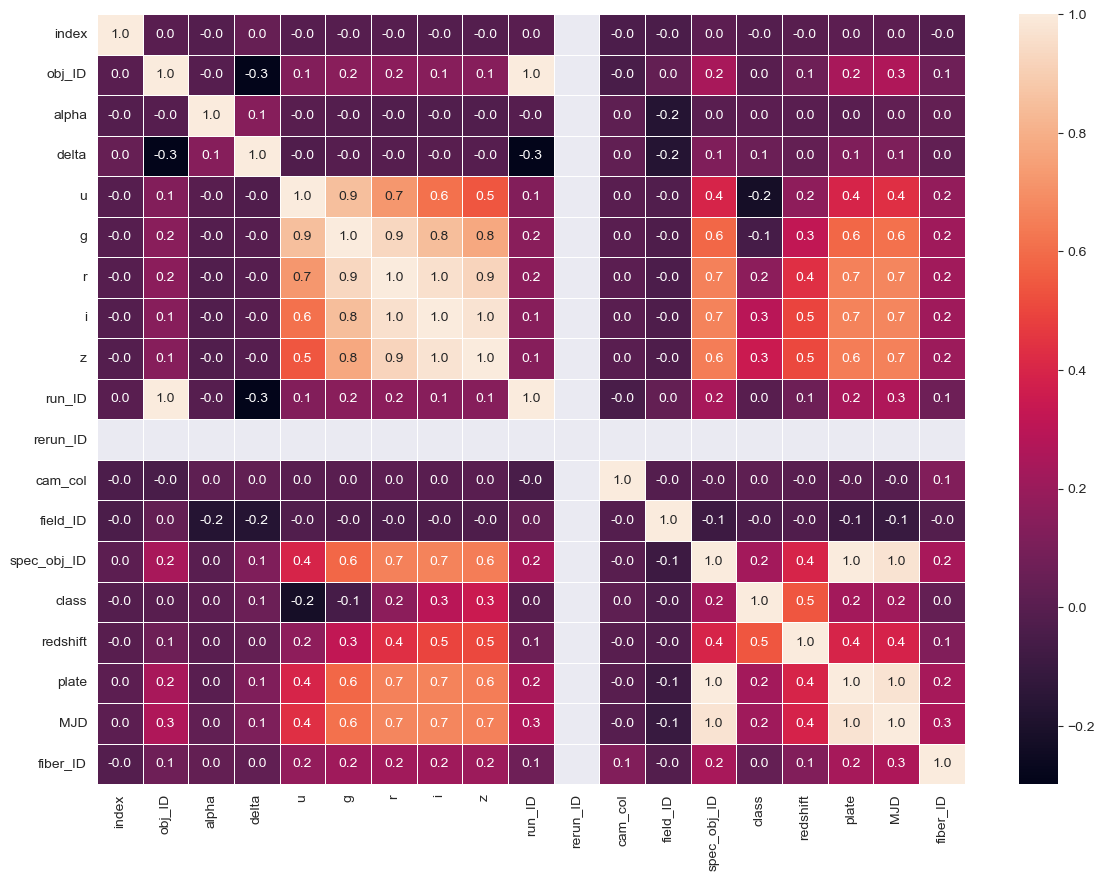

In [10]:
plt.figure(figsize = (14,10))
sns.heatmap(df.corr(), annot=True, fmt= ".1f", linewidths= .7)
plt.show()

In [11]:
# check correlation between values and the resulting class
correlation = df.corr()
correlation["class"].sort_values()

u             -0.222756
g             -0.058155
field_ID      -0.037529
index         -0.010190
run_ID         0.000245
obj_ID         0.000247
alpha          0.008183
cam_col        0.017749
fiber_ID       0.037349
delta          0.058952
r              0.160680
MJD            0.214441
spec_obj_ID    0.224728
plate          0.224729
i              0.294096
z              0.349730
redshift       0.541684
class          1.000000
rerun_ID            NaN
Name: class, dtype: float64

In [12]:
# therefore we can drop the columns that do not have a positive/negative (between -0.5 and 0.5) or a NaN correlation with the class column
df.drop(["field_ID", "run_ID", "obj_ID", "alpha", "cam_col", "fiber_ID", "delta", "rerun_ID"], axis=1, inplace=True)

In [13]:
df.head()

,index,u,g,r,i,z,spec_obj_ID,class,redshift,plate,MJD
0,0,23.87882,22.27530,20.39501,19.16573,18.79371,6.543777e+18,0,0.634794,5812,56354
1,1,24.77759,22.83188,22.58444,21.16812,21.61427,1.176014e+19,0,0.779136,10445,58158
2,3,22.13682,23.77656,21.61162,20.50454,19.25010,1.030107e+19,0,0.932346,9149,58039
3,4,19.43718,17.58028,16.49747,15.97711,15.54461,6.891865e+18,0,0.116123,6121,56187
4,6,21.46973,21.17624,20.92829,20.60826,20.42573,1.246262e+19,2,0.586455,11069,58456


## Data Imbalance

In [14]:
# assign x as the df without the class column, and y as the value of the class column.
x = df.drop(["class"], axis = 1)
y = df.loc[:, "class"].values

In [15]:
# correct data imbalances by using SMOTE technique to duplicate values and fit_resample to resample minority classes.
sm = SMOTE(random_state = 39)
print("Original Dataset Shape %s" % Counter(y))
x, y = sm.fit_resample(x, y)
print("Resampled Dataset Shape %s" % Counter(y))

Original Dataset Shape Counter({0: 50696, 1: 17890, 2: 16158})
Resampled Dataset Shape Counter({0: 50696, 2: 50696, 1: 50696})


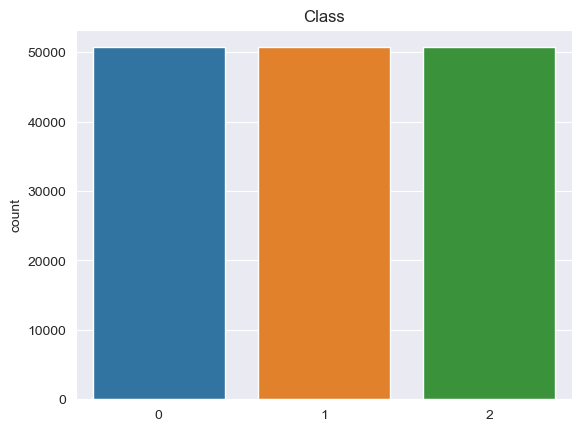

In [16]:
# plot of classes after resampling.
sns.countplot(y)
plt.title("Class")
plt.show()

## PCA

In [17]:
# standardize the 'x' dataset by removing the mean and scaling to unit variance.
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [18]:
# performs (PCA) on the 'x' dataset, selects the top 4 principal components, and combines them with the 'y' dataset, creating a final dataset 'final_DF'.
y = pd.DataFrame(y, columns=["class"])
# pca = PCA(0.95) otherwise causing a bug which 95 percentage takes first 5 columns
pca = PCA(n_components=4)
p_Components = pca.fit_transform(x)
p_DF = pd.DataFrame(data= p_Components, columns= ["Principal Components 1", "Principle Components 2", "Principal Components 3", "Principal Components 4"])
final_DF = pd.concat([p_DF, y[["class"]]], axis=1)
final_DF

,Principal Components 1,Principle Components 2,Principal Components 3,Principal Components 4,class
0,-0.883257,-0.739525,1.615270,-1.029071,0
1,-4.015447,-0.013855,1.651894,-1.221522,0
2,-2.726177,0.403192,1.716317,-0.958770,0
3,2.880111,2.235507,1.799290,-1.235652,0
4,-2.697647,1.636983,1.806126,-1.067984,2
...,...,...,...,...,...
152083,-2.319673,-0.603426,0.453002,0.009649,2
152084,-1.501550,0.304811,0.775061,1.132149,2
152085,-0.896412,1.261690,1.502191,0.556505,2
152086,-2.351839,1.402355,-0.765195,1.805587,2


## Train & Test Data Split

In [20]:
x_train, x_test, y_train, y_test = train_test_split(p_DF, y, test_size= 0.33, random_state=42)
print("x_train: {}".format(x_train.shape))
print("x_test: {}".format(x_test.shape))
print("y_train: {}".format(y_train.shape))
print("y_test: {}".format(y_test.shape))

x_train: (101898, 4)
x_test: (50190, 4)
y_train: (101898, 1)
y_test: (50190, 1)


# Modelling

In [21]:
# function to evaluate the models
def evaluate(pred, pred_prob):
    print(f"Accuracy: {accuracy_score(y_test, pred)}\n")
    print(f"Confusion Matrix: \n{confusion_matrix(y_test, pred)}\n")
    print(f"Classification Report: \n{classification_report(y_test, pred)}\n")
    fpr, tpr, thresholds = roc_curve(y_test, pred_prob)
    auc = roc_auc_score(y_test, pred_prob)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

Fitting Random Forest with default parameters

n_estimators=100,
criterion='gini',
max_depth=None,
min_samples_split=2,
min_samples_leaf=1,
min_weight_fraction_leaf=0.0,
max_features='auto',
max_leaf_nodes=None,
min_impurity_decrease=0.0,
bootstrap=True,
oob_score=False,
n_jobs=None,
random_state=None,
verbose=0,
warm_start=False,
class_weight=None,
ccp_alpha=0.0,
max_samples=None

In [ ]:
rf_model = RandomForestClassifier(random_state=123456)

In [ ]:
rf_model.fit(x_train, y_train)

In [ ]:
y_predicted = rf_model.predict(x_test)

## Accuracy and report of RF with default parameters

In [ ]:
accuracy_score(y_test, y_predicted)

In [ ]:
cm = confusion_matrix(y_test, y_predicted)

In [ ]:
class_names = ['GALAXY','STAR','QSO']
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names,)
plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.show()

In [ ]:
print(classification_report(y_test, y_predicted))

## RF with Hyper-Parameter Optimization

Default RF parameters

n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None,

In [ ]:
param = {
    'n_estimators': [25, 50, 100, 150],
    'criterion' : ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9],
        }
rf_grid_search = GridSearchCV(estimator = rf_model, param_grid = param, cv=5)

In [ ]:
rf_grid_search.fit(x_train, y_train) #KeyboardInterrupted

since the model has taken significant amount of time to train again with tuning, considering randomized iterations below

In [ ]:
rf_random_search = RandomizedSearchCV(estimator=rf_model,param_distributions=param, cv=5, n_iter=2,random_state=6)

In [ ]:
rf_random_search.fit(x_train, y_train)

In [ ]:
rf_random_search.best_score_

In this case Hyper-Parameter Tuning doesn't work and default parameters are considered to be the best

In [ ]:
y_predicted_train = rf_model.predict(x_train)

testing_accuracy = accuracy_score(y_test, y_predicted)
training_accuracy = accuracy_score(y_train, y_predicted_train)

print("training accuracy : ",training_accuracy)
print("testing accuracy : ",testing_accuracy)


## LR Model

In [ ]:
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')
lr.fit(x_train, y_train)

In [ ]:
y_predicted = lr.predict(x_test)
y_predicted

In [ ]:
# Evaluate Model
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_predicted)
print(cm)

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_predicted))

## Support Vector Machine (SVM) Model

In [ ]:
svm = SVC(kernel="rbf", C=4)
svm.fit(x_train, y_train)

In [ ]:
svm_pred = svm.predict(x_test)
accuracy_score(svm_pred, y_test)

# Ensemble Modelling

In [ ]:
kfold = model_selection.KFold(n_splits=5, shuffle=True)
estimators = []
estimators.append(("logistic", lr))
estimators.append(("svm", svm))

In [ ]:
ensemble_model = VotingClassifier(estimators, voting='hard')
results = model_selection.cross_val_score(ensemble_model, x_train, y_train, cv=kfold, n_jobs=1)

In [ ]:
ENSM_score = np.mean(results)
print(f"Accuracy: {ENSM_score}")